<a href="https://colab.research.google.com/github/ayoubbensakhria/finance_algo/blob/master/ARMA_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

An ARMA model, or Autoregressive Moving Average model, is used to describe weakly stationary stochastic time series in terms of two polynomials. The first of these polynomials is for autoregression, the second for the moving average.

Often this model is referred to as the ARMA(p,q) model; where:

* p is the order of the autoregressive polynomial,
* q is the order of the moving average polynomial.

The equation is given by:

\begin{align}
        \mathbf{x_t} = \mathbf{w_t} + \sum_{i=1}^q \alpha_i x_{t-i} + \sum_{i=1}^p \beta_i w_{t-i}
        &
    \end{align}


In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from datetime import datetime, timedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from time import time
%matplotlib inline
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')


# Vizualise the Stock Price Over Time

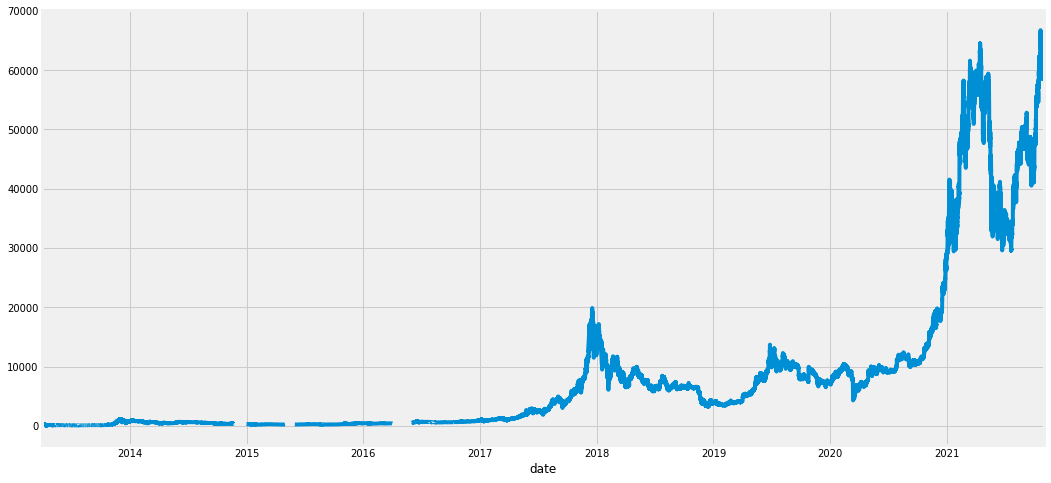

In [47]:
#read data
df = pd.read_csv('/content/drive/MyDrive/Yoctobe Fintech/Datasets/btcusd30mn.csv', parse_dates=True)
df.head()
# #setting index as date because some statsmodels might not work
df.rename(columns={'datetime': 'date'}, inplace=True)
df.index = df['date']
df.index = pd.to_datetime(df.index)
#plot
df['close'].plot(figsize=(16,8))

In [48]:
df = df.drop(columns =['open', 'high', 'low', 'volume', 'date'])
df.head()

,close
date,
2013-04-01 00:00:00,94.120499
2013-04-01 00:30:00,93.250000
2013-04-01 01:00:00,93.422576
2013-04-01 01:30:00,93.100000
2013-04-01 02:00:00,93.189997


# Identify the correct ARMA Model Order
## Visualising ACF Plot and PACF Plots
The bars inside the blue shaded region then they are not statistically significant.
* PACF is the autocorrelation that is just associated with just k lags
* PACF cuts off after lag k = q; ACF cuts off after lag k = p; 

"Cuts off" means that it becomes zero abruptly, and "tails off" means that it decays to zero asymptotically (usually exponentially).

The PACF "cuts off" after the 2nd lag, while the ACF "tails off" to zero. You probably have something like an AR(2).



In [49]:
ddf = df.resample("D").mean()
# using a range of dates
mask = (ddf.index > '2018-01-01') & (ddf.index <= '2021-01-01')
ddf = ddf.loc[mask]

# Tain Dataset

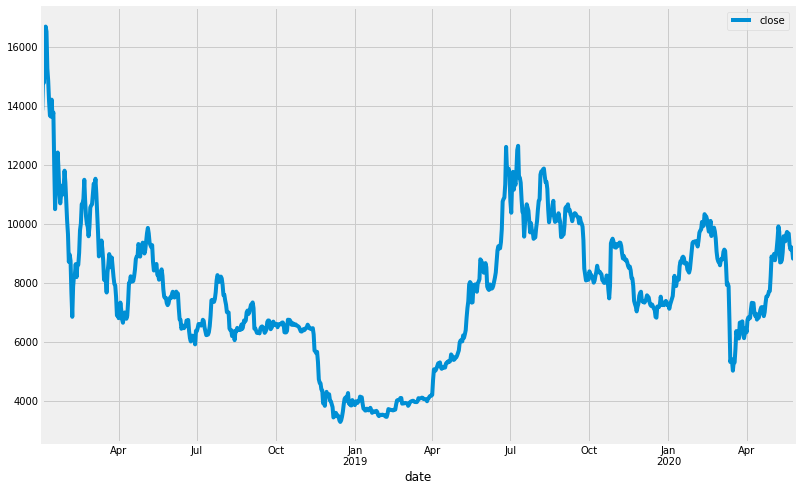

In [50]:
df_train, df_valid = train_test_split(ddf, train_size = 0.8, shuffle=False)
df_train.plot(figsize=(12,8))

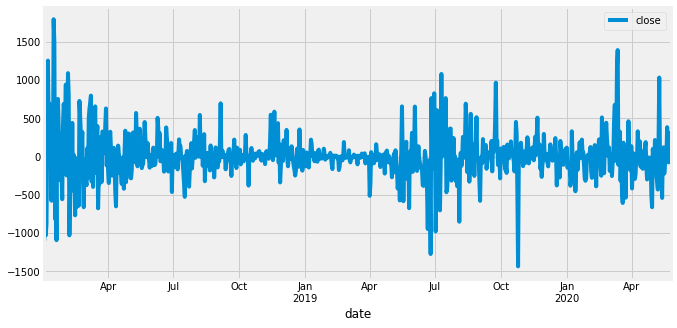

In [51]:

df_train.shift(-1).head(5)
# Difference the stock price and make it stationary
#A stationary process has the property that the mean, variance and autocorrelation structure do not change over time.
df1_train = df_train - df_train.shift(-1)
df1_train.dropna(inplace=True)
df1_train.plot(figsize = (10,5))


# Stationarity
Mathimatically, stationarity of a time series is defined as the requirement that for every m and n, the distributions: \begin{align}
        \mathbf (Y_1, Y_2, Y_3, ..., Y_n) \\and\\  (Y_{1+m}, Y_{2+m}, Y_{3+m}, ..., Y_{n+m})
        &
    \end{align} are the same.

Strong stationarity : all the aspects of the stochastic process remain unchanged, constant in time.
Weak stationarity : only mean, variance, and covariance remain unchanged.
The simplest example of weakly stationary process is White Noise defined with increasingly restrictive assumptions: 
\begin{align}
 \mathbf E(Y_t) = {μ} \\  Var(Y_t) = σ^2 \\  Cov(Y_t, Y_s) = 0
        &
    \end{align}

Where the best predictor is the Mean.

In [52]:
#test stationarity
print('Results of Dickey-Fuller Test:')
dftest = sm.tsa.adfuller(df1_train['close'])
dfoutput = pd.Series(dftest[0:4], 
                     index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -1.033192e+01
p-value                        2.827848e-18
#Lags Used                     7.000000e+00
Number of Observations Used    8.670000e+02
Critical Value (1%)           -3.437915e+00
Critical Value (5%)           -2.864879e+00
Critical Value (10%)          -2.568548e+00
dtype: float64


# Plot ACF PACF

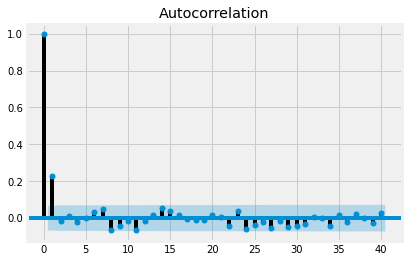

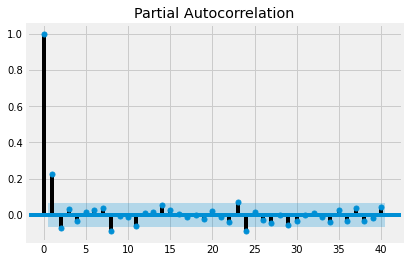

In [55]:
acf = sm.tsa.graphics.plot_acf(df1_train['close'], lags=40)
pacf = sm.tsa.graphics.plot_pacf(df1_train['close'], lags=40)

In [56]:
#By selecting aic as criteria, decide the order.
sm.tsa.stattools.arma_order_select_ic(df1_train['close'], ic='aic')

{'aic':               0             1             2
 0  12408.716424  12358.620280  12359.790117
 1  12364.171504  12359.568677  12360.114655
 2  12361.431229  12360.289019  12362.390675
 3  12362.159772  12362.099170  12363.848340
 4  12363.136640  12364.099138  12363.701332, 'aic_min_order': (0, 1)}

In [57]:
#fit the model_1
mod = sm.tsa.ARIMA(df_train, order = (1,0,2), freq='D')
result = mod.fit()
print(result.summary())

                              ARMA Model Results                              
Dep. Variable:                  close   No. Observations:                  876
Model:                     ARMA(1, 2)   Log Likelihood               -6183.676
Method:                       css-mle   S.D. of innovations            280.745
Date:                Thu, 11 Nov 2021   AIC                          12377.352
Time:                        19:41:59   BIC                          12401.229
Sample:                    01-02-2018   HQIC                         12386.485
                         - 05-26-2020                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        8457.1835   1295.483      6.528      0.000    5918.084     1.1e+04
ar.L1.close     0.9915      0.005    210.138      0.000       0.982       1.001
ma.L1.close     0.2579      0.034      7.506    

In [ ]:
#fit the model_1
mod1 = sm.tsa.ARIMA(df_train, order = (2,0,2), freq='D')
result1 = mod1.fit()
print(result1.summary())

                              ARMA Model Results                              
Dep. Variable:                  close   No. Observations:                  537
Model:                     ARMA(2, 2)   Log Likelihood               -3733.000
Method:                       css-mle   S.D. of innovations            251.711
Date:                Thu, 11 Nov 2021   AIC                           7478.000
Time:                        18:55:30   BIC                           7503.716
Sample:                    03-02-2019   HQIC                          7488.060
                         - 08-19-2020                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        8283.0729   1412.262      5.865      0.000    5515.090    1.11e+04
ar.L1.close     0.9567      0.343      2.786      0.006       0.284       1.630
ar.L2.close     0.0352      0.340      0.104    

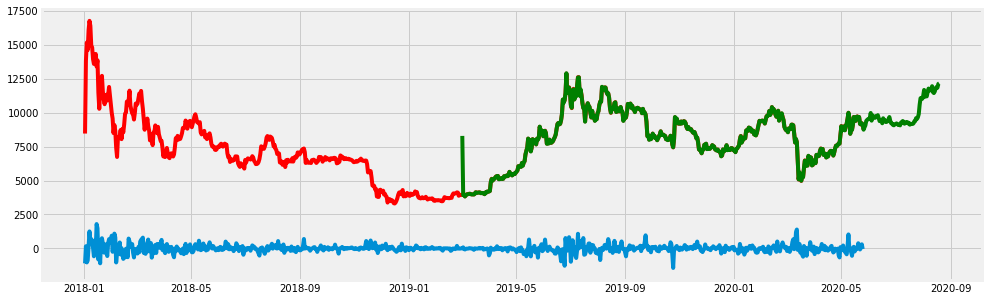

In [58]:
plt.figure(figsize=(15,5))
plt.plot(df1_train)
plt.plot(result.fittedvalues, color='red')
plt.plot(result1.fittedvalues, color='green')
plt.show()

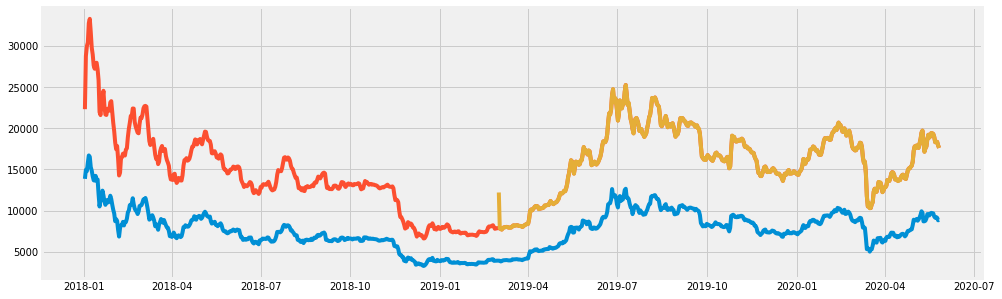

In [59]:
#take back to original scale
df_estimated = pd.DataFrame(result.fittedvalues,columns=['close'],copy=False)
df_origin = df_estimated['close'] + df_train['close']
df_origin.dropna(inplace=True)

#take back to original scale model_2
df1_estimated = pd.DataFrame(result1.fittedvalues,columns=['close'],copy=False)
df1_origin = df1_estimated['close'] + df_train['close']
df1_origin.dropna(inplace=True)

plt.figure(figsize=(15,5))
plt.plot(df_train['close'])
plt.plot(df_origin)
plt.plot(df1_origin)
plt.show()

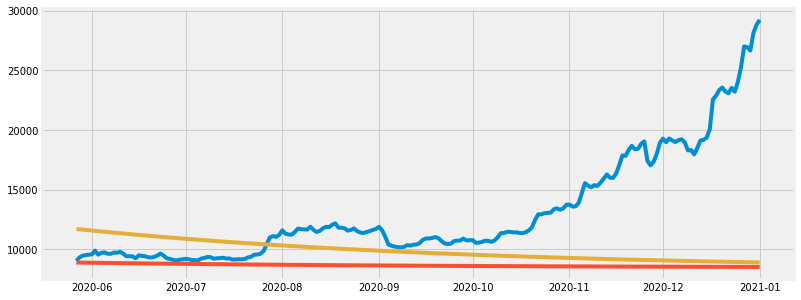

In [60]:
#make predictions and compared it to the validation dataset
forecast = pd.DataFrame(result.forecast(len(df_valid['close']))[0],
                        columns=['forecasted values'], index=df_valid.index)

#make predictions and compared it to the validation dataset
forecast1 = pd.DataFrame(result1.forecast(len(df_valid['close']))[0],
                        columns=['forecasted values'], index=df_valid.index)

plt.figure(figsize=(12,5))
plt.plot(df_valid['close'])
plt.plot(forecast['forecasted values'])
plt.plot(forecast1['forecasted values'])
plt.show()

In [64]:
df_diff = ddf - ddf.shift(-1)
df_diff.dropna(inplace = True)

#fit the model to the whole dataset
model_final = sm.tsa.ARIMA(ddf, order = (0,1,2), freq = 'D')
result_final = model_final.fit()
print(result_final.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                 1095
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -7782.112
Method:                       css-mle   S.D. of innovations            295.294
Date:                Thu, 11 Nov 2021   AIC                          15572.224
Time:                        19:43:25   BIC                          15592.218
Sample:                    01-03-2018   HQIC                         15579.789
                         - 01-01-2021                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            14.4509     11.482      1.259      0.208      -8.053      36.955
ma.L1.D.close     0.2969      0.030      9.816      0.000       0.238       0.356
ma.L2.D.close    -0.0099      0.030     

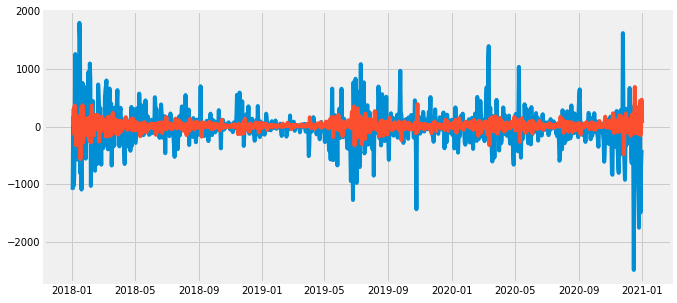

In [65]:
plt.figure(figsize=(10,5))
plt.plot(df_diff)
plt.plot(result_final.fittedvalues)
plt.show()

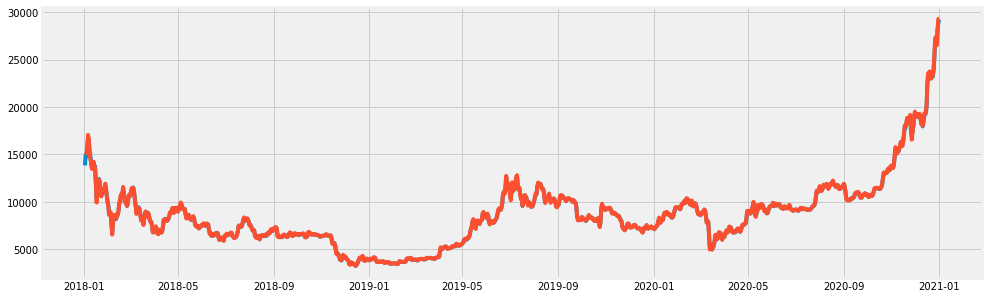

In [66]:
df_estimated_final = pd.DataFrame(result_final.fittedvalues,columns=['close'],copy=False)
df_origin_final = df_estimated_final['close'] + ddf['close']
df_origin_final.dropna(inplace=True)
plt.figure(figsize=(15,5))
plt.plot(ddf['close'])
plt.plot(df_origin_final)
plt.show()

In [68]:
df_origin_final

date
2018-01-03    14959.107103
2018-01-04    15088.047613
2018-01-05    15674.778388
2018-01-06    17053.515622
2018-01-07    16677.895406
                  ...     
2020-12-28    27394.549234
2020-12-29    26515.902249
2020-12-30    28126.108181
2020-12-31    29292.504262
2021-01-01    29295.732967
Freq: D, Name: close, Length: 1095, dtype: float64

In [77]:
result_actual = df.resample('D').mean()
mask = (result_actual.index > '2021-01-01') & (result_actual.index <= '2021-03-01')
result_actual = result_actual.loc[mask]
forcast_date_range = result_actual.index.to_numpy()

59


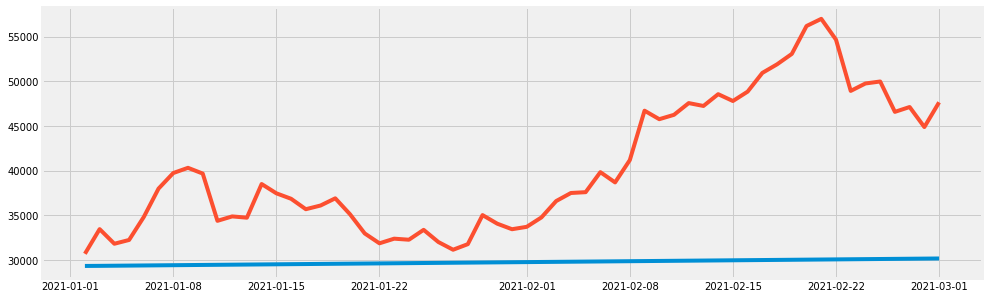

In [76]:
forecast_final = pd.DataFrame(result_final.forecast(steps=59)[0], columns= ['forcasetd values'], index=forcast_date_range)
forecast_final['forcasetd values']
plt.figure(figsize=(15,5))
plt.plot(forecast_final)
plt.plot(result_actual)
plt.show()
